# Modular TRM Training for Community Detection

This notebook demonstrates a modular approach to training and evaluating a TRM neural network for community detection on synthetic graphs using PyTorch. The code is organized for easy adaptation to other graph-based problems.

## 1. Import Libraries and Set Up Environment
Import all required libraries, set random seeds, and configure device (CPU/GPU).

In [158]:
import os, math, random
from dataclasses import dataclass
from typing import Tuple, Any, List
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append(os.path.join("..", "src"))
from exploretinyrm.trm import TRM, TRMConfig
def set_seed(seed: int = 123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import networkx as nx

Device: cuda


## 2. AMP and EMA Utilities
Define automatic mixed precision (AMP) and exponential moving average (EMA) utility functions and classes.

In [159]:
try:
    from torch.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = True
except ImportError:
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = False

def make_grad_scaler(is_cuda: bool):
    if _USE_TORCH_AMP:
        try:
            return _GradScaler("cuda", enabled=is_cuda)
        except TypeError:
            return _GradScaler(enabled=is_cuda)
    else:
        return _GradScaler(enabled=is_cuda)

def amp_autocast(is_cuda: bool, use_amp: bool):
    if _USE_TORCH_AMP:
        try:
            return _autocast(device_type="cuda", enabled=(is_cuda and use_amp))
        except TypeError:
            return _autocast(enabled=(is_cuda and use_amp))
    else:
        return _autocast(enabled=(is_cuda and use_amp))

class EMA:
    def __init__(self, model: torch.nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {
            name: param.detach().clone()
            for name, param in model.named_parameters()
            if param.requires_grad
        }

    def update(self, model: torch.nn.Module) -> None:
        d = self.decay
        with torch.no_grad():
            for name, param in model.named_parameters():
                if not param.requires_grad:
                    continue
                self.shadow[name].mul_(d).add_(param.detach(), alpha=1.0 - d)

    def copy_to(self, model: torch.nn.Module) -> None:
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in self.shadow:
                    param.copy_(self.shadow[name])

from contextlib import contextmanager

@contextmanager
def use_ema_weights(model: torch.nn.Module, ema: EMA):
    backup = {
        name: param.detach().clone()
        for name, param in model.named_parameters()
        if param.requires_grad
    }
    ema.copy_to(model)
    try:
        yield
    finally:
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in backup:
                    param.copy_(backup[name])

## 3. Community Detection Dataset Preparation
Synthetic dataset for community detection

In [160]:
class GameDataset(Dataset):
    """Base class for game datasets. Subclass and implement _generate_sample."""
    def __init__(self, n_samples: int, seed: int = 0):
        self.rng = np.random.default_rng(seed)
        self.samples = [self._generate_sample() for _ in range(n_samples)]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]
    def _generate_sample(self): raise NotImplementedError()

class CommunityDetectionDataset(GameDataset):
    """Synthetic SBM community detection puzzles."""
    def __init__(self, n_samples: int, n_nodes: int = 30, n_communities: int = 3, p_in: float = 0.6, p_out: float = 0.05, seed: int = 0):
        self.n_nodes = n_nodes
        self.n_communities = n_communities
        self.p_in = p_in
        self.p_out = p_out
        self.rng = np.random.default_rng(seed)
        self.samples = [self._generate_sample() for _ in range(n_samples)]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]
    def _generate_sample(self):
        sizes = [self.n_nodes // self.n_communities] * self.n_communities
        for i in range(self.n_nodes % self.n_communities):
            sizes[i] += 1
        probs = np.full((self.n_communities, self.n_communities), self.p_out)
        np.fill_diagonal(probs, self.p_in)
        G = nx.stochastic_block_model(sizes, probs, seed=int(self.rng.integers(1e9)))
        labels = []
        for idx, size in enumerate(sizes):
            labels.extend([idx] * size)
        labels = np.array(labels)
        adj = nx.to_numpy_array(G)
        x_tokens = adj.flatten()
        x_tokens = torch.from_numpy(x_tokens.astype(np.int64))  # [n_nodes, n_nodes]
        y_tokens = torch.from_numpy(labels.astype(np.int64))  # [n_nodes]
        return x_tokens, y_tokens

def get_gc_loaders(n_train=512, n_val=128, batch_size=16, n_nodes=30, n_communities=3, p_in=0.6, p_out=0.05, seed=42):
    ds_tr = CommunityDetectionDataset(n_samples=n_train, n_nodes=n_nodes, n_communities=n_communities, p_in=p_in, p_out=p_out, seed=seed)
    ds_va = CommunityDetectionDataset(n_samples=n_val, n_nodes=n_nodes, n_communities=n_communities, p_in=p_in, p_out=p_out, seed=seed+1)
    return (
        DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True),
        DataLoader(ds_va, batch_size=batch_size, shuffle=False, pin_memory=True)
    )

train_loader, val_loader = get_gc_loaders(
    n_train=2048,
    n_val=512,
    batch_size=16,
    n_nodes=5, #N_NODES
    n_communities=3,
    p_in=0.6,
    p_out=0.05,
    seed=123
)

In [161]:
# show some examples of the dataset
for i in range(2):
    x, y = train_loader.dataset[i]
    print(f"Example {i}:")
    print(x.shape, y.shape)

Example 0:
torch.Size([25]) torch.Size([5])
Example 1:
torch.Size([25]) torch.Size([5])


In [162]:
N_NODES = 5
N_COMMUNITIES = 3
INPUT_TOKENS = 2  # adjacency values: 0 or 1 (float)
OUTPUT_TOKENS = N_COMMUNITIES
SEQ_LEN = N_NODES * N_NODES

D_MODEL = 128
N_SUP = 16
N = 6
T = 3
USE_ATT = False

In [172]:
# show some examples of the dataset
for i in range(2):
    x, y = train_loader.dataset[i]
    print(f"Example {i}:")
    print("Input Adjacency Matrix:")
    adj_matrix = x.numpy().reshape(N_NODES, N_NODES)
    print(adj_matrix)
    print(type(adj_matrix))
    print("Node Colors:")
    print(y.numpy())
    print(type(y.numpy()))

Example 0:
Input Adjacency Matrix:
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 1 0]]
<class 'numpy.ndarray'>
Node Colors:
[0 0 1 1 2]
<class 'numpy.ndarray'>
Example 1:
Input Adjacency Matrix:
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
<class 'numpy.ndarray'>
Node Colors:
[0 0 1 1 2]
<class 'numpy.ndarray'>


## 4. Model Configuration for Community Detection
Define the input/output vocabularies, sequence encoding, and instantiate the TRM model for node classification.

In [164]:

cfg = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=D_MODEL,
    n_layers=2,
    use_attention=USE_ATT,
    n_heads=8,
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=N,
    T=T,
    k_last_ops=None,
    stabilize_input_sums=True
)

model = TRM(cfg).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-4, weight_decay=0.0, betas=(0.9, 0.95)
)

scaler = make_grad_scaler(device.type == "cuda")
ema = EMA(model, decay=0.999)

Params (M): 0.399752


## 5. Training Loop
Train the TRM model to predict community labels from the adjacency matrix, using permutation-invariant loss and accuracy metrics.

In [ ]:
def compute_class_weights(loader, n_classes):
    # Count occurrences of each class in the dataset
    counts = torch.zeros(n_classes)
    for _, y_true in loader:
        for c in range(n_classes):
            counts[c] += (y_true == c).sum().item()
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * n_classes
    return weights

class_weights = compute_class_weights(train_loader, N_COMMUNITIES).to(device)

def node_ce_loss(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    # logits: [B, N, C], y_true: [B, N]
    B, N, C = logits.shape
    return F.cross_entropy(logits.reshape(B*N, C), y_true.reshape(B*N), weight=class_weights)

import itertools

def coloring_max_match(preds, y_true, n_colors):
    """Return the max number of matches over all color permutations, normalized by number of nodes."""
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    y_true = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    max_match = 0
    for perm in itertools.permutations(range(n_colors)):
        mapping = {i: perm[i] for i in range(n_colors)}
        mapped_preds = [mapping[c] for c in preds]
        match = sum(mp == yt for mp, yt in zip(mapped_preds, y_true))
        if match > max_match:
            max_match = match
    return max_match / len(preds)

def node_exact_match_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = logits.argmax(dim=-1)
    # For each sample in batch, get max match score
    batch_scores = []
    for i in range(preds.shape[0]):
        score = coloring_max_match(preds[i], y_true[i], N_COMMUNITIES)
        batch_scores.append(score)
    return torch.tensor(batch_scores, device=logits.device)

def train_one_epoch(
    model: TRM,
    loader: DataLoader,
    optimizer,
    scaler,
    epoch: int,
    use_amp: bool = True,
    ema: "EMA | None" = None
):
    model.train()
    total_ce, total_halt, total_em, total_steps = 0.0, 0.0, 0.0, 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device, non_blocking=True)
        y_true   = y_true.to(device,   non_blocking=True)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(N_SUP):
            optimizer.zero_grad(set_to_none=True)
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
            )
            logits_nodes = logits.float().view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
            loss_ce = F.cross_entropy(logits_nodes.reshape(-1, OUTPUT_TOKENS), y_true.reshape(-1),
                                      weight=class_weights)
            # loss_ce = node_ce_loss(logits_nodes.float(), y_true)
            with torch.no_grad():
                em = node_exact_match_from_logits(logits_nodes, y_true)

            # correct_indices = (em == 1.0).nonzero(as_tuple=True)[0]
            # for idx in correct_indices:
            #     print(f"Example {idx.item()}:")
            #     print("Logits:")
            #     print(logits_nodes[idx])
            #     print("Predicted colors:", logits_nodes[idx].argmax(dim=-1))
            #     print("True colors:", y_true[idx])

            loss_halt = F.binary_cross_entropy_with_logits(halt_logit.float(), em)
            loss = loss_ce + loss_halt
            if use_amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                if ema is not None:
                    ema.update(model)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if ema is not None:
                    ema.update(model)
            total_ce   += loss_ce.detach().item()
            total_halt += loss_halt.detach().item()
            total_em   += em.mean().item()
            total_steps += 1
    print(f"Epoch {epoch:02d} | CE {total_ce/max(1,total_steps):.4f} | HaltBCE {total_halt/max(1,total_steps):.4f} | Perm-inv match {total_em/max(1,total_steps):.3f}")

@torch.no_grad()
def evaluate(model: TRM, loader: DataLoader, n_sup_eval: int = N_SUP, show_examples: int = 3):
    model.eval()
    acc_list = []
    example_count = 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(n_sup_eval):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
            )
        logits_nodes = logits.float().view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
        em = node_exact_match_from_logits(logits_nodes, y_true)
        acc = em.mean()
        acc_list.append(acc)
        # Print a few examples from the first batch
        if example_count < show_examples:
            preds = logits_nodes.argmax(dim=-1)
            xs = x_tokens.cpu().numpy()
            ys = y_true.cpu().numpy()
            preds_np = preds.cpu().numpy()
            logits_np = logits_nodes.cpu().numpy()
            for i in range(min(show_examples - example_count, xs.shape[0])):
                print(f"\nExample {example_count + 1}:")
                print("Adjacency matrix:")
                print(xs[i].reshape(N_NODES, N_NODES))
                print("Logits:")
                print(logits_np[i])
                print("Predicted communities:", preds_np[i])
                print("True communities:", ys[i])
                print("Perm-inv match score:", coloring_max_match(preds_np[i], ys[i], N_COMMUNITIES))
                example_count += 1
    acc = torch.stack(acc_list).mean().item()
    print(f"Validation | Perm-inv node match {acc:.3f}")
    return acc

@torch.no_grad()
def evaluate_with_ema(model: TRM, ema: EMA, loader: DataLoader, n_sup_eval: int = N_SUP):
    with use_ema_weights(model, ema):
        return evaluate(model, loader, n_sup_eval=n_sup_eval)


In [166]:
EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    train_one_epoch(model, train_loader, optimizer, scaler, epoch, use_amp=False, ema=ema)
    acc_raw = evaluate(model, val_loader)
    acc_ema = evaluate_with_ema(model, ema, val_loader)
    print(f"Validation (raw) | Node accuracy {acc_raw:.3f}")
    print(f"Validation (EMA) | Node accuracy {acc_ema:.3f}")

Epoch 01 | CE 0.0487 | HaltBCE 0.0690 | Perm-inv match 0.982

Example 1:
Adjacency matrix:
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Logits:
[[  8.520408  -11.113164  -12.024961 ]
 [  8.341815  -11.317797  -11.648746 ]
 [-10.242337    8.9866295 -10.367754 ]
 [-10.312874    8.662589   -9.985393 ]
 [ -8.042514   -6.6232758  12.607787 ]]
Predicted communities: [0 0 1 1 2]
True communities: [0 0 1 1 2]
Perm-inv match score: 1.0

Example 2:
Adjacency matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
Logits:
[[  8.162518  -11.281556  -11.602969 ]
 [  7.9855638 -11.413016  -11.289719 ]
 [-10.150333    9.744103  -10.97937  ]
 [-10.103192    9.25622   -10.582431 ]
 [ -7.1975756  -7.695514   12.732875 ]]
Predicted communities: [0 0 1 1 2]
True communities: [0 0 1 1 2]
Perm-inv match score: 1.0

Example 3:
Adjacency matrix:
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Logits:
[[  8.520408  -11.113164  -12.024961 ]
 [  8.341815  

## 5. Evaluation and Visualization
Evaluate the trained TRM model on synthetic graphs and visualize the detected communities.

Validation | Perm-inv node match 1.000
Node accuracy history: 1.0
Example:
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
Prediction:
 [0 0 1 1 2]
Labels:
 [0 0 1 1 2]


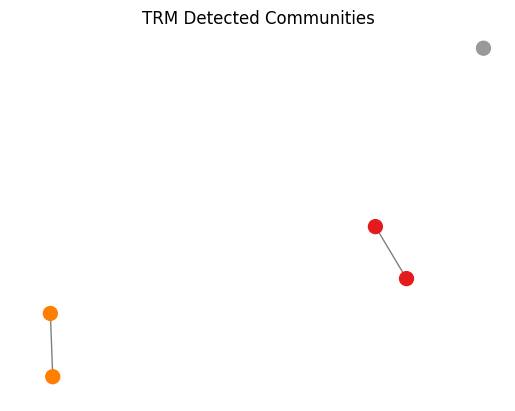

In [184]:
@torch.no_grad()
def forward(model: TRM, x_tokens: torch.Tensor, n_sup_eval: int = N_SUP):
    model.eval()
    x_tokens = x_tokens.to(device)
    y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
    for _ in range(n_sup_eval):
        y_state, z_state, logits, halt_logit = model.forward_step(
            x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
        )
    logits_nodes = logits.float().view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
    preds = logits_nodes.argmax(dim=-1)
    return preds

avg_acc = evaluate(model, val_loader, show_examples=0)
print("Node accuracy history:", avg_acc)

print("Example:")
# Visualization
import matplotlib.pyplot as plt
x, y = CommunityDetectionDataset(n_samples=1, n_nodes=N_NODES, n_communities=N_COMMUNITIES, seed=10)[0]
adj = x.numpy().reshape(N_NODES, N_NODES)
G_nx = nx.from_numpy_array(adj)
pos = nx.spring_layout(G_nx, seed=42)
preds = forward(model, torch.from_numpy(adj.flatten()).unsqueeze(0).to(device).long()).cpu().numpy()[0]
print(adj)
print("Prediction:\n",preds)
print("Labels:\n",y.numpy())
nx.draw_networkx_nodes(G_nx, pos, node_color=preds, cmap=plt.cm.Set1, node_size=100)
nx.draw_networkx_edges(G_nx, pos, alpha=0.5)
plt.title("TRM Detected Communities")
plt.axis('off')
plt.show()